<a href="https://colab.research.google.com/github/sho-kawano/profit-gain/blob/master/Training_DistilBERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training a Hugging Face Transformer
Here I train and save a Hugging Face Transformer that classifies the 20 News Groups Data.

In [ ]:
# Check that we have a GPU
!nvidia-smi

Tue Sep 15 03:02:14 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install ktrain

In [ ]:
!pip install pympler

     |████████████████████████████████| 184kB 2.8MB/s 
  Created wheel for pympler: filename=Pympler-0.8-cp36-none-any.whl size=164714 sha256=a6a71cadf9f60af071b24456cdfcadd0a8dfc46d0b030847fd2876e2d75d80a3
  Stored in directory: /root/.cache/pip/wheels/6c/61/cc/4bdf1e8c8b1c04d8104322eb2508b6a21d4d3a4d1b44fdd510
Successfully built pympler


WARNING: You have to restart the session in order for the rest of the code to work

# *Step 1:*  Load Data


In [ ]:
from sklearn.datasets import fetch_20newsgroups

mydata_train = fetch_20newsgroups(subset='train',
                             remove = ('headers', 'footers', 'quotes'),
                             shuffle=True, random_state=42)
mydata_test = fetch_20newsgroups(subset='test',
                            remove = ('headers', 'footers', 'quotes'),
                            shuffle=True, random_state=42)

print('size of training set: %s' % (len(mydata_train['data'])))
print('size of validation set: %s' % (len(mydata_test['data'])))
print('classes: %s' % (mydata_train.target_names))

size of training set: 11314
size of validation set: 7532
classes: ['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


In [ ]:
import ktrain
from ktrain import text

In [ ]:
x_train = mydata_train.data
y_train = mydata_train.target
x_test = mydata_test.data
y_test = mydata_test.target

In [ ]:
MODEL_NAME = 'distilbert-base-uncased'
t = text.Transformer(MODEL_NAME, maxlen=500, class_names=mydata_train.target_names)
trn = t.preprocess_train(x_train, y_train)
val = t.preprocess_test(x_test, y_test)
model = t.get_classifier()
learner = ktrain.get_learner(model, train_data=trn, val_data=val, batch_size=6)


preprocessing train...
language: en
train sequence lengths:
	mean : 186
	95percentile : 572
	99percentile : 1789


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 175
	95percentile : 543
	99percentile : 1658


In [ ]:
x_train[1:5]

["A fair number of brave souls who upgraded their SI clock oscillator have\nshared their experiences for this poll. Please send a brief message detailing\nyour experiences with the procedure. Top speed attained, CPU rated speed,\nadd on cards and adapters, heat sinks, hour of usage per day, floppy disk\nfunctionality with 800 and 1.4 m floppies are especially requested.\n\nI will be summarizing in the next two days, so please add to the network\nknowledge base if you have done the clock upgrade and haven't answered this\npoll. Thanks.",
 'well folks, my mac plus finally gave up the ghost this weekend after\nstarting life as a 512k way back in 1985.  sooo, i\'m in the market for a\nnew machine a bit sooner than i intended to be...\n\ni\'m looking into picking up a powerbook 160 or maybe 180 and have a bunch\nof questions that (hopefully) somebody can answer:\n\n* does anybody know any dirt on when the next round of powerbook\nintroductions are expected?  i\'d heard the 185c was supposed

In [ ]:
# there are 20 categories so the numbers here correspond to a certain newsgroup
y_train[1:5]

array([ 4,  4,  1, 14])

#STEP 2: Estimate a Good Learning Rate
Learning rates between 2e-5 and 5e-5 tend to work well with transformer models based on papers from Google. However, we will run our learning-rate-finder for two epochs to estimate the LR on this particular dataset.

As shown below, our results are consistent Google's findings.

simulating training for different learning rates... this may take a few moments...
Epoch 1/2
1885/1885 [==============================] - 423s 224ms/step - loss: 2.3757 - accuracy: 0.3873
Epoch 2/2
1885/1885 [==============================] - 425s 225ms/step - loss: 3.6571 - accuracy: 0.0498


done.
Visually inspect loss plot and select learning rate associated with falling loss


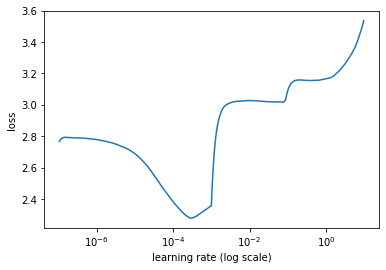

In [ ]:
learner.lr_find(show_plot=True, max_epochs=2)

#STEP 3: Training a Model


The `learner.fit_onecycle` method employs a [1cycle learning rate policy](https://arxiv.org/pdf/1803.09820.pdf).  The



In [ ]:
learner.fit_onecycle(10e-5, 4)



begin training using onecycle policy with max lr of 0.0001...
Epoch 1/4
1886/1886 [==============================] - 498s 264ms/step - loss: 0.1358 - accuracy: 0.9607 - val_loss: 1.6690 - val_accuracy: 0.6706
Epoch 2/4
1886/1886 [==============================] - 500s 265ms/step - loss: 0.2911 - accuracy: 0.9167 - val_loss: 1.5296 - val_accuracy: 0.6719
Epoch 3/4
1886/1886 [==============================] - 499s 265ms/step - loss: 0.2271 - accuracy: 0.9334 - val_loss: 1.6297 - val_accuracy: 0.6893
Epoch 4/4
1886/1886 [==============================] - 497s 264ms/step - loss: 0.1185 - accuracy: 0.9649 - val_loss: 1.6261 - val_accuracy: 0.6993


So we see here that the ultimate model has an accuracy of 70%.

In [ ]:
learner.validate(class_names=t.get_classes())

                          precision    recall  f1-score   support

             alt.atheism       0.51      0.50      0.51       319
           comp.graphics       0.65      0.73      0.69       389
 comp.os.ms-windows.misc       0.72      0.54      0.62       394
comp.sys.ibm.pc.hardware       0.63      0.67      0.65       392
   comp.sys.mac.hardware       0.73      0.71      0.72       385
          comp.windows.x       0.77      0.77      0.77       395
            misc.forsale       0.81      0.83      0.82       390
               rec.autos       0.54      0.76      0.63       396
         rec.motorcycles       0.68      0.76      0.72       398
      rec.sport.baseball       0.92      0.81      0.86       397
        rec.sport.hockey       0.85      0.88      0.87       399
               sci.crypt       0.81      0.71      0.76       396
         sci.electronics       0.61      0.59      0.60       393
                 sci.med       0.81      0.77      0.79       396
         

array([[160,   2,   0,   0,   0,   1,   1,  10,   8,   1,   6,   5,   0,
          4,  11,  22,   8,   7,   7,  66],
       [  0, 285,  10,   9,  10,  34,   5,   5,   3,   1,   1,   5,   6,
          3,   7,   2,   0,   1,   1,   1],
       [  6,  29, 213,  52,  14,  22,   2,  18,   5,   1,   2,   3,   9,
          1,   9,   0,   1,   1,   3,   3],
       [  0,  17,  21, 261,  31,  10,   8,   9,   4,   0,   0,   4,  23,
          0,   1,   0,   0,   3,   0,   0],
       [  0,   9,   7,  30, 272,   4,   8,  16,   3,   0,   1,   7,  20,
          1,   3,   0,   0,   1,   2,   1],
       [  0,  41,  19,   5,   6, 305,   2,   6,   1,   0,   1,   4,   4,
          0,   1,   0,   0,   0,   0,   0],
       [  1,   2,   2,  11,  10,   3, 325,  13,   7,   1,   2,   1,   7,
          1,   1,   0,   0,   2,   1,   0],
       [  5,   4,   2,   2,   5,   0,  12, 301,  31,   0,   3,   2,  13,
          1,   4,   0,   4,   2,   4,   1],
       [  4,   2,   4,   2,   1,   0,   4,  29, 304,   2,   8,  

#STEP 4: Save the Model

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
bert_predictor = ktrain.get_predictor(learner.model, preproc=t)

In [ ]:
bert_predictor.save('/content/gdrive/My Drive/Colab Notebooks/ML_Profit-Gain/DistilBERT_predictor')

In [ ]:
# reload the predictor
bert_predictor = ktrain.load_predictor('/content/gdrive/My Drive/Colab Notebooks/ML_Profit-Gain/DistilBERT_predictor')